<center> <h1> <b> Investigating the Impact of Income Inequality on COVID-19 Mortality and How Prevention Policy Moderates this Relationship</b> </h1> </center>

# Project One #

## Introduction ##

Countries with weaker economies are more fragile to the COVID-19 outbreak. High levels of income inequality is a key feature of fragile economies, with particular disadvantages when facing pandemics. A study shows that high inequality weakens social resilience, as low-income groups lack savings and are more vulnerable to shocks (Furceri, Loungani, & Ostry, 2021). Meanwhile, another study of 22 OECD countries suggests economies with high inequality tend to have higher COVID-19 mortality as low-income groups have less access to health services (Sepulveda & Brooker, 2021). Similarly, regional studies have reported similar findings (Kawachi & Subramanian, 2020). Therefore, it is important for vulnerable countries to take effective measures to protect themselves.

One common practice is to implement prevention policies. Vaccination, quarantine, and mask mandates ect. are effective in preventing the spread of virus (Chu et al., 2020). However, stringent policies can bring economic costs, including lower GDP growth, increased unemployment, and supply chain disruptions (Baker, Wilson, & Anglemyer, 2020). For fragile economies with large portion of low-income population, these economic costs can exacerbate the situation. Therefore, finding a trade-off is crucial. This study expands the scope from OECD countries to include a wider range of nations to estimate COVID-19 mortality across various levels of income inequality, and explore the suitability of strict prevention policies for countries in different income inequality levels.
    
Many articles provide the basis for this study. Studies mentioned earlier used the **Gini coefficient** as a measure of income inequality to examine its effect on **COVID-19 mortality** (Sepulveda & Brooker, 2021). Additionally, another paper used the **Stringent Index** in estimating the effectiveness of the strict prevention policy during the pandemic (Hale et al., 2021; Hsiang et al., 2020). In addition, there are studies that applied **multivariable linear regression** for modeling COVID-19 Mortality suggested that **GDP per capita**, number of **hospital beds**, and **population density** have a statistically significant relationship with the COVID-19 mortality (Motallebi et al., 2021; Chen et al., 2021). This provides the inspiration of proper quantification of the **variable of interst**, **modeling framework** and **control variables** in this study.

This study applies GLM regression with fixed effects to model the COVID-19 Mortality across 66 countries spanning from 2020 to 2022. Result shows that countries with higher Gini Index tend to have higher Marginal Mortality, and high Stringent index has a worse effect of reducing Marginal Mortality for countries with very highe income inequality. This provides a theoretical reference for countries to customize prevention policies base on their economic features, especially highlighting the importance for countries with high inequality to impose appropreate preventions.

## Data Cleaning and Loading ##

Data used are all country-level data. The **Marginal Mortality** of COVID-19 is the outcome variable calculated by the monthly increased number of deaths, sourced from the COVID-19 dataset (main data source), divided by population, sourced from the World Bank. 

$$
\text{Marginal Mortality} = \frac{\text{Monthly Increased Deaths}}{\text{Population}}
$$

The variable of interest is the **Gini index**, sourced from the World Bank. A higher Gini Index indicating higher income inequality.
Similarly, the **Stringent Index**, sourced from Oxford Database, measures the overall tightness of government policies. A higher Stringent Index indicates that stricter preventive measures have been implemented.
**GDP per capita**, the number of **hospital beds**, and **population density** serve as control variables to establish a good model, all sourced from the World Bank.

The following shows the data loading and preprocessing process. The code has been optimized to the minimum. Noticing that the COVID-19 dataset refers to countries differently compared to other sources. Therefore, ChatGPT is used to identify the difference in references, and then manually standardize country names across datasets. Regional data (e.g., Beijing, China) are aggregated to country-level.

In [1]:
# Load the first dataset, including countries and their accumulated COVID-19 death count
import pandas as pd

file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\time_series_covid19_deaths_global.csv"
Death_data = pd.read_csv(file_path)
Death_data = Death_data.drop(columns=['Province/State', 'Long', 'Lat'], errors='ignore')
Death_data.columns = [col if col == "Country/Region" else pd.to_datetime(col, errors='coerce').date() for col in Death_data.columns]
date_columns = Death_data.columns[1:]

start_date = pd.to_datetime("2020-02-01").date()
end_date = pd.to_datetime("2022-12-31").date()
monthly_dates = pd.date_range(start=start_date, end=end_date, freq='MS').date
available_dates = [min(date_columns, key=lambda x: abs(x - d)) for d in monthly_dates if min(date_columns, key=lambda x: abs(x - d)) in date_columns]
columns_to_keep = ["Country/Region"] + available_dates
Death_data_filtered = Death_data[columns_to_keep].copy()
Death_data_filtered.rename(columns={'Country/Region': 'Country Name'}, inplace=True)

# Sum regional data
Death_data_filtered = Death_data_filtered.groupby("Country Name", as_index=False).sum()

# Standardize country names
Death_data_filtered['Country Name'] = Death_data_filtered['Country Name'].replace('US', 'United States')
Death_data_filtered.replace({
    'Bahamas': 'Bahamas, The',
    'Bosnia': 'Bosnia and Herzegovina',
    'Brunei': 'Brunei Darussalam',
    'Myanmar': 'Burma',
    'Cape Verde': 'Cabo Verde',
    'Congo (Kinshasa)': 'Congo, Dem. Rep.',
    'Congo (Brazzaville)': 'Congo, Rep.',
    'Ivory Coast': "Cote d'Ivoire",
    'Swaziland': 'Eswatini',
    'Gambia': 'Gambia, The',
    'Vatican City': 'Holy See',
    'Korea, South': 'Korea, Rep.',
    'Korea, North': 'Korea, Dem. People\'s Rep.',
    'Laos': 'Lao PDR',
    'Lebanon': 'Lebanese Republic',
    'North Macedonia': 'Macedonia',
    'Vietnam': 'Viet Nam',
    'Yemen': 'Yemen, Rep.'
}, inplace=True)

The Stringent index is also recorded monthly.

In [2]:
# Load the 2nd dataset, including the stringent index
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\OXFORD-CGRT.xlsx"
stringent = pd.read_excel(file_path)

stringent_id = stringent[stringent["Indicator ID"] == "OXFORD.CGRT.stringency_index"]
stringent = stringent_id.drop(columns=['Economy ISO3', 'Indicator ID', 'Indicator', 'Attribute 1', 'Attribute 2', 'Attribute 3', 'Partner'], errors='ignore')
stringent.columns = [col if col == "Economy Name" else pd.to_datetime(col, errors='coerce').date() for col in stringent.columns]

columns_to_keep = ["Economy Name"] + available_dates
stringent_filtered = stringent[columns_to_keep].copy()
stringent_filtered.rename(columns={'Economy Name': 'Country Name'}, inplace=True)

Gini Index, population, population density, and hospital beds are annual data and some observations gap in certain years. I first filtered out countries with no data from 2020 to 2022. Then, I filled the NAs with the most recent update to ensure consistency in the analysis.

In [3]:
#Load the 3rd dataset, including countries and their GDP per capita
pd.set_option('future.no_silent_downcasting', True)
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\GDP.csv"
GDP = pd.read_csv(file_path)
GDP_keep = ['Country Name', '2020', '2021', '2022'] 
GDP_filtered = GDP[GDP_keep]
GDP_filtered_cleaned = GDP_filtered[GDP_filtered.iloc[:, 1:].notna().any(axis=1)]
GDP_filtered_cleaned_filled = GDP_filtered_cleaned.bfill(axis=1).ffill(axis=1)

In [4]:
#Load the 4th dataset, including the population density of each country 
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\population_density.csv"
pop_den = pd.read_csv(file_path)
pop_den_keep = ['Country Name', '2020', '2021', '2022'] 
pop_den_filtered = pop_den[pop_den_keep]
pop_den_filtered_cleaned = pop_den_filtered[pop_den_filtered.iloc[:, 1:].notna().any(axis=1)]
pop_den_filtered_cleaned_filled = pop_den_filtered_cleaned.bfill(axis=1).ffill(axis=1)

In [5]:
#Load the 5th dataset, including the hospital beds of each country
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\hospital_beds.csv"
hospital_beds = pd.read_csv(file_path)
hospital_beds_keep = ['Country Name', '2020', '2021', '2022'] 
hospital_beds_filtered = hospital_beds[hospital_beds_keep]
hospital_beds_filtered_cleaned = hospital_beds_filtered[hospital_beds_filtered.iloc[:, 1:].notna().any(axis=1)]
hospital_beds_filtered_cleaned_filled = hospital_beds_filtered_cleaned.bfill(axis=1).ffill(axis=1)

In [6]:
#Load the 6th dataset, including the gini coefficient of each country
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\API_SI.POV.GINI_DS2_en_csv_v2_53.csv"
gini = pd.read_csv(file_path, skiprows=4)
gini_keep = ['Country Name', '2020', '2021', '2022'] 
gini_filtered = gini[gini_keep]
gini_filtered_cleaned = gini_filtered[gini_filtered.iloc[:, 1:].notna().any(axis=1)]
gini_filtered_cleaned_filled = gini_filtered_cleaned.bfill(axis=1).ffill(axis=1)

In [7]:
#Load the 7th dataset, including the population of each country
file_path = r"C:\Users\chenr\OneDrive\ECO225Project\Data\variables\API_SP.POP.TOTL_DS2_en_csv_v2_87.csv"
population = pd.read_csv(file_path, skiprows=4)
population_keep = ['Country Name', '2020', '2021', '2022'] 
population_filtered = population[population_keep]
population_filtered_cleaned = population_filtered[population_filtered.iloc[:, 1:].notna().any(axis=1)]
population_filtered_cleaned_filled = population_filtered_cleaned.bfill(axis=1).ffill(axis=1)

Then, we merge the data.

In [8]:
#merge data base on date and country for annual data
GDP_melted = pd.melt(GDP_filtered_cleaned_filled, id_vars=['Country Name'], var_name='year', value_name='GDP per capita')
Pop_den_melted = pd.melt(pop_den_filtered_cleaned_filled, id_vars=['Country Name'], var_name='year', value_name='Population Density')
hospital_beds_melted = pd.melt(hospital_beds_filtered_cleaned_filled, id_vars=['Country Name'], var_name='year', value_name='Hospital Beds')
Gini_melted = pd.melt(gini_filtered_cleaned_filled, id_vars=['Country Name'], var_name='year', value_name='Gini Index')
Population_melted = pd.melt(population_filtered_cleaned_filled, id_vars=['Country Name'], var_name='year', value_name='Population')

tables = [Gini_melted, GDP_melted, Pop_den_melted, Population_melted, hospital_beds_melted]
from functools import reduce
year_table = reduce(lambda left, right: left.merge(right, on=['Country Name', 'year'], how='inner'), tables)
unique_countries = year_table['Country Name'].unique()

In [9]:
#merge data base on date and country for number of deaths and Stringent index
death_df = Death_data_filtered[Death_data_filtered['Country Name'].isin(unique_countries)]
death_melted = pd.melt(death_df, id_vars=['Country Name'], var_name='date', value_name='Cumulative Death')
stringent_filtered = stringent_filtered[stringent_filtered['Country Name'].isin(unique_countries)]
Stringent_melted = pd.melt(stringent_filtered, id_vars=['Country Name'], var_name='date', value_name='Stringent Index')

date_table = death_melted.merge(Stringent_melted, on=['Country Name', 'date'], how='inner')

unique_countries1 = date_table['Country Name'].unique()
print(str(len(unique_countries1)) + " countries are covered in the study.")

66 countries are covered in the study.


Calculate the Marginal Mortality and log Marginal Mortality. Noticing there are a few negative Marginal Mortality values. These are likely due to statistical errors and adjustments, making them meaningless. Therefore, they are removed from the dataset.

In [54]:
# Merge year table and date table
date_table['year'] = pd.to_datetime(date_table['date']).dt.year.astype(int)
year_table['year'] = year_table['year'].astype(int)

merged_data = date_table.merge(year_table, on=['Country Name', 'year'], how='inner')

merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['Month'] = merged_data['date'].dt.to_period('M').astype(str) 

# Keep 2020-03-01 data as it is 
mar_1_data = merged_data[merged_data['date'] == '2020-03-01'][['Country Name', 'Cumulative Death']]

# Calculate Marginal Death
merged_data['Marginal Death'] = merged_data.groupby('Country Name')['Cumulative Death'].diff()
merged_data.loc[merged_data['Month'] == '2020-03', 'Marginal Death'] = \
    merged_data['Country Name'].map(mar_1_data.set_index('Country Name')['Cumulative Death'])

# Calcullate Marginal Mortality（per 100k population）
merged_data['Marginal Mortality'] = (merged_data['Marginal Death'] / merged_data['Population']) * 100000
merged_data = merged_data[merged_data['Marginal Mortality'] >= 0]

#merged_data.drop(columns=['Cumulative Death', 'Marginal Death', 'Population'], inplace=True)
# convert data type for further analysis
cols_to_convert = ['Gini Index', 'GDP per capita', 'Population Density', 'Hospital Beds', 'Marginal Mortality', 'Marginal Death', 'Population']
for col in cols_to_convert:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Take log for future regressions
import numpy as np
merged_data['Log Marginal Mortality'] = np.log(merged_data['Marginal Mortality'].replace(0, np.nan))

Finally, I group observations based on their Gini Index into five categories and named the new variable 'Gini Category' to examine how different inequality levels affect COVID-19 death rate.

In [55]:
# group countries based on their gini Index
bins = [0, 20, 30, 40, 50, float('inf')]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

merged_data['Gini Category'] = pd.cut(merged_data['Gini Index'], bins=bins, labels=labels, right=False)

## Summary Statistics Tables ##

The following table shows the distribution of each variable. The average Marginal Mortality is 6.16, meaning about 6 people per 100000 population in average dead by COVID-19 in a month. The mean is comparatively closer to the minimum than the maximum, suggesting a strong right-skewed distribution. Additionally, the variance of Marginal Mortality is about 10.0^2 = 100, which is much bigger than its mean, indicating overdispersion. This suggests that I should take **right-skew** and **overdispersion** into consideration in further analysis especially when selecting the regression model. 

<h4 style='text-align: center;'>Table 1: Statistical Properties of All Variables</h4>

In [303]:
columns_of_interest = ['Log Marginal Mortality', 'Marginal Mortality', 'Gini Index', 'Stringent Index', 'Population Density', 'GDP per capita', 
                       'Hospital Beds']
summary_stats = merged_data[columns_of_interest].agg(
    ['max', 'mean', 'min', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]
).transpose()
summary_stats.columns = ['Maximum', 'Mean', 'Minimum', 'Std. Dev.', '25th Quantile', '75th Quantile']
summary_stats_df = pd.DataFrame(summary_stats)
summary_stats_df = summary_stats_df.transpose()

display(summary_stats_df)

,Log Marginal Mortality,Marginal Mortality,Gini Index,Stringent Index,Population Density,GDP per capita,Hospital Beds
Maximum,4.291180,73.052594,55.100000,100.000000,1660.971875,133711.794400,12.750000
Mean,0.538764,6.159276,35.181855,45.559679,152.643062,22926.736425,3.610076
Minimum,-9.554710,0.000000,24.000000,0.000000,2.136237,579.512496,0.200000
Std. Dev.,2.175023,10.033386,6.627602,24.859349,222.693993,25893.610004,2.474063
25th Quantile,-0.512949,0.335085,30.000000,24.070000,36.299741,5083.606955,1.680000
75th Quantile,2.050770,7.211908,39.600000,66.670000,199.559269,31796.821340,5.350000


The table below provides an overview of the distribution of each variable across different Gini Category groups. No country in the dataset belongs to the Very Low Gini category. However, I keep the empty group to maintain consistency. The mean log Marginal Mortality increases across Gini Categories: Medium < High < Very High, consistent with findings linking higher inequality to higher COVID-19 mortality (Sepulveda & Brooker, 2021). However, the Low group falls between High and Very High, likely due to less stringent policies and poorer pandemic control over time.

<h4 style='text-align: center;'>Table 2: Statistical Properties of All Variables Grouped by Gini Category</h4>

In [304]:
country_summary_stats = merged_data.groupby('Country Name')[columns_of_interest].agg(
    [lambda x: x.quantile(0.25), 'mean', lambda x: x.quantile(0.75), 'std', 'min', 'max']
)
country_summary_stats = country_summary_stats.stack(level=1, future_stack=True)
merged_stats = country_summary_stats.reset_index().merge(
    merged_data[['Country Name', 'Gini Category']].drop_duplicates(), 
    on='Country Name', 
    how='left'
)
gini_summary_stats = merged_stats.groupby('Gini Category', observed=False)[columns_of_interest].agg(
    [lambda x: x.quantile(0.25), 'mean', lambda x: x.quantile(0.75), 'std', 'min', 'max']
)
gini_summary_stats = gini_summary_stats.stack(level=1, future_stack=True)

display(gini_summary_stats)

Log Marginal Mortality  Marginal Mortality  \
Gini Category                                                          
Very Low      <lambda_0>                     NaN                 NaN   
              mean                           NaN                 NaN   
              <lambda_1>                     NaN                 NaN   
              std                            NaN                 NaN   
              min                            NaN                 NaN   
              max                            NaN                 NaN   
Low           <lambda_0>               -0.200247            0.710128   
              mean                      0.922184           10.773430   
              <lambda_1>                2.198265           14.231869   
              std                       1.955496           15.004095   
              min                      -5.300046            0.000000   
              max                       4.235028           69.063597   
Medium        <lambda_0>               -1.565791            0.059208   
              mean                      0.140391            7.450470   
              <lambda_1>                1.849137            9.394501   
              std                       2.666655           11.854720   
              min                      -9.554710            0.000000   
              max                       4.119791           61.546353   
High          <lambda_0>               -0.099590            1.244231   
              mean                      0.852376           11.625618   
              <lambda_1>                2.148788           12.947145   
              std                       2.422720           16.123972   
              min                      -8.106294            0.000000   
              max                       4.291180           73.052594   
Very High     <lambda_0>                0.497785            1.589780   
              mean                      1.152766           10.506380   
              <lambda_1>                2.373710           11.312080   
              std                       1.905390           11.755486   
              min                      -3.393916            0.000000   
              max                       3.654372           38.643229   

                          Gini Index  Stringent Index  Population Density  \
Gini Category                                                               
Very Low      <lambda_0>         NaN              NaN                 NaN   
              mean               NaN              NaN                 NaN   
              <lambda_1>         NaN              NaN                 NaN   
              std                NaN              NaN                 NaN   
              min                NaN              NaN                 NaN   
              max                NaN              NaN                 NaN   
Low           <lambda_0>   25.600000        16.491250           18.279809   
              mean         23.193974        39.739384          103.561972   
              <lambda_1>   29.200000        59.783750          109.571631   
              std          10.468078        27.543301          126.567142   
              min           0.000000         0.000000            0.035683   
              max          30.700000        96.300000          525.719691   
Medium        <lambda_0>   30.700000        18.536877           30.486616   
              mean         28.744910        40.932739          162.703019   
              <lambda_1>   35.455882        63.890000          218.634470   
              std          13.040850        27.806144          261.342307   
              min           0.000000         0.000000            0.027494   
              max          41.300000       100.000000         1660.971875   
High          <lambda_0>   40.200000        22.353248           16.565617   
              mean         36.039049        43.751422           67.920776   
              <lambda_1>   

## Visualizations ##

The distribution of the dependent variable can guide the selection of appropriate statistical methods. The graph below is a histogram showing the distribution of Marginal Mortality. It is count data (Marginal death adjusted by population), right-skewed, and with no excess zeros, which aligns with the assumptions of a **generalized Poisson or Negative Binomial distribution**. Therefore, we use log marginal mortality in the subsequent analysis.

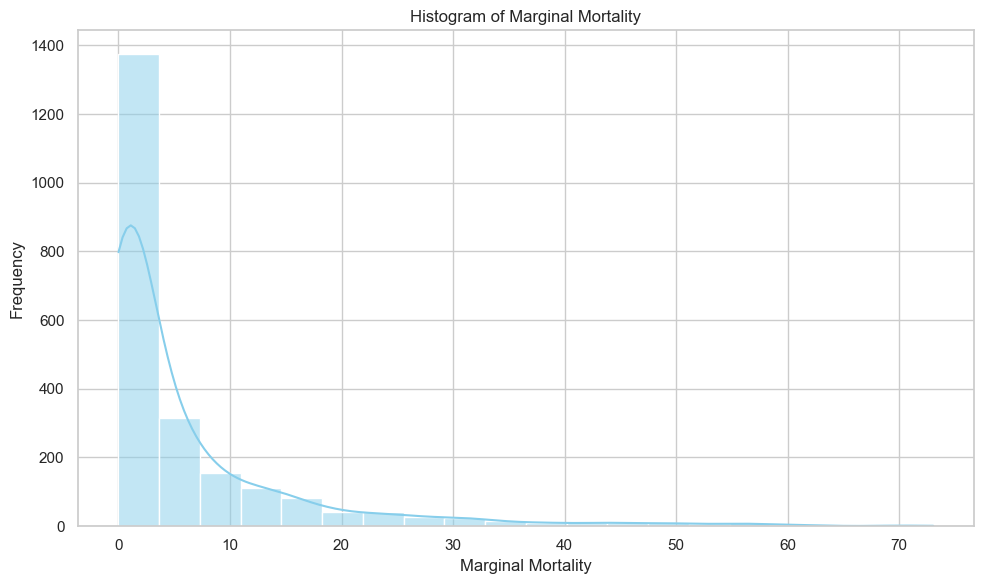

In [305]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.histplot(merged_data['Marginal Mortality'], kde=True, bins=20, color='skyblue')

plt.title("Histogram of Marginal Mortality")
plt.xlabel("Marginal Mortality")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

The pie charts show the cpmposition of Gini category in the dataset for each year. This color palette will apply to all following graph. There are about 75% of countries fall into the Medium and Low categories, while around 25% are in the High and Very High categories. The table shows which countries changed their Gini category and the year of the change. Since countries have their own fetures that effect the mortality, **countries fixed effect** may need to be considered in regressions. 

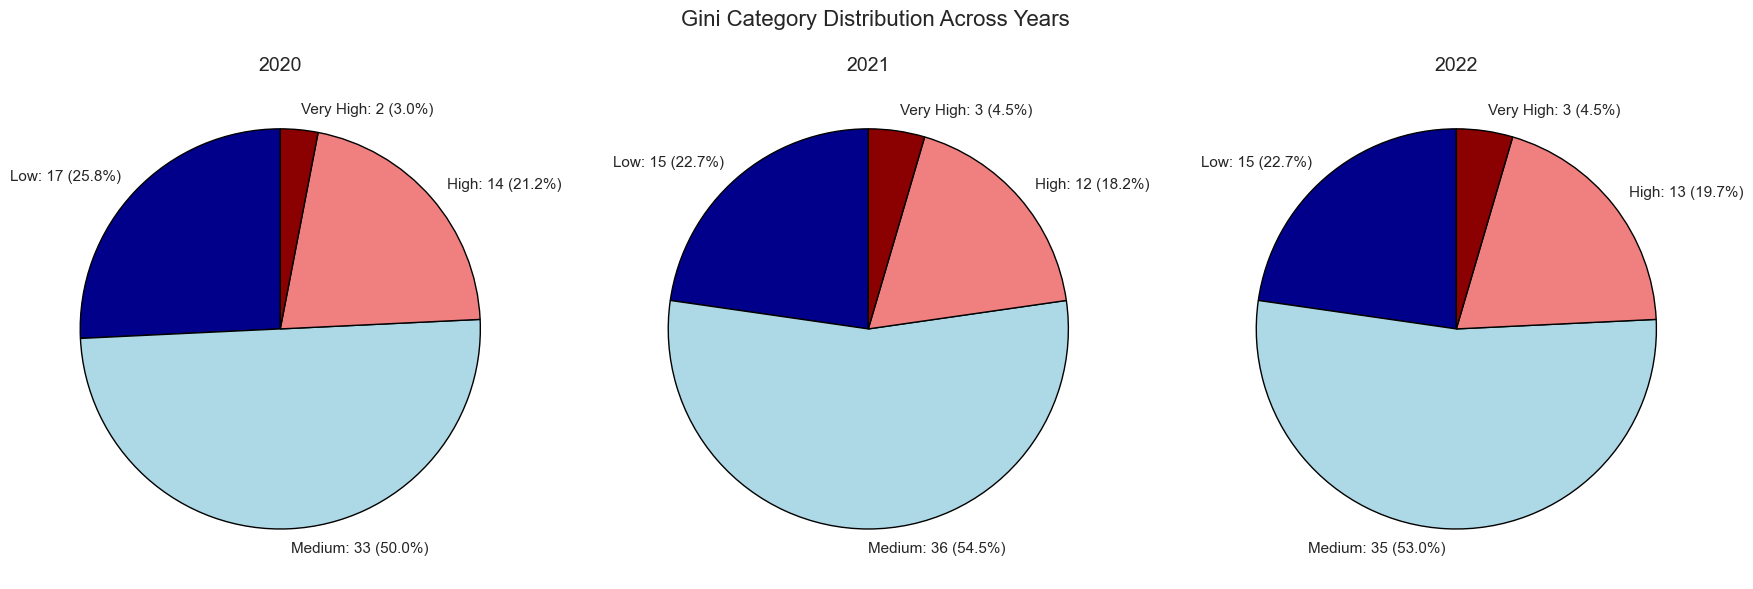

,Country Name,Previous Category,New Category,Change Year
0,Austria,Low,Medium,2021
1,Brazil,High,Very High,2021
2,Bulgaria,High,Medium,2021
3,Ireland,Low,Medium,2021
4,United States,Medium,High,2022


In [306]:
# set color for each Gini category
gini_colors = {
    'Very High': 'darkred',
    'High': 'lightcoral',
    'Medium': 'lightblue',
    'Low': 'darkblue',
    'Very Low': 'black'
}

# draw pie charts
gini_category_counts = merged_data.groupby(['year', 'Gini Category'], observed=False)['Country Name'].nunique().reset_index()
gini_category_counts.rename(columns={'Country Name': 'Number of Countries'}, inplace=True)
gini_category_counts = gini_category_counts[gini_category_counts['Gini Category'] != 'Very Low']
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
for i, year in enumerate(gini_category_counts['year'].unique()):
    year_data = gini_category_counts[gini_category_counts['year'] == year]
    
    labels = [f"{cat}: {num} ({num / year_data['Number of Countries'].sum() * 100:.1f}%)"
              for cat, num in zip(year_data['Gini Category'], year_data['Number of Countries'])]
    
    wedges, texts = axes[i].pie(
        year_data['Number of Countries'],
        labels=labels,
        startangle=90,
        colors=[gini_colors[cat] for cat in year_data['Gini Category']],
        wedgeprops={'edgecolor': 'black'}, 
        autopct=None  
    )
    axes[i].set_title(f'{year}', fontsize=14)
fig.suptitle('Gini Category Distribution Across Years', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

# identify countries with category changes and indicate the type and time of change
merged_data_sorted = merged_data[['Country Name', 'year', 'Gini Category']].sort_values(by=['Country Name', 'year'])

category_changes = []

for country in merged_data_sorted['Country Name'].unique():
    country_data = merged_data_sorted[merged_data_sorted['Country Name'] == country]
    
    for i in range(1, len(country_data)):
        if country_data.iloc[i]['Gini Category'] != country_data.iloc[i-1]['Gini Category']:
            category_changes.append({
                'Country Name': country,
                'Previous Category': country_data.iloc[i-1]['Gini Category'],
                'New Category': country_data.iloc[i]['Gini Category'],
                'Change Year': country_data.iloc[i]['year']
            })

category_changes_df = pd.DataFrame(category_changes)
def color_category(val):
    return f'color: {gini_colors.get(val, "black")}' 

category_changes_styled = category_changes_df.style.map(color_category, subset=['Previous Category', 'New Category'])

category_changes_styled

Now we explore other features of the dependent variable. The line graph shows the mean marginal mortality over time, grouped by Gini category. Several key messages can be drawn from it. 

Firstly, countries in Low and Medium shows similar trend over time, while High and Very High shows similar trend over time. This again align with the literature finding (Sepulveda & Brooker, 2021), suggesting that gini index is a potential factor that effects the marginal mortality. 

There is approximately one outbreak per year. Low and Medium Gini countries experience outbreaks first in winter (yellow lines), followed by High and Very High Gini countries about a quarter later (orange lines). This pattern aligns with studies showing COVID-19 spreads more rapidly in cold seasons due to climate, behavior, and immunity changes (Kissler et al., 2020; Sajadi et al., 2020). Globally, the first outbreak occurred in early 2020, the second in late 2020 to early 2021 (winter and Alpha variants), and the third in late 2021 to early 2022 (Omicron variant) (WHO, 2021; ECDC, 2021). This implies that we have to take **time series effect** into consideration when doing regressions.

Lastly, during the first two outbreaks, High and Very High report higher mean marginal mortality. However, in the third outbreak, the trend reverses: the mean marginal mortality for Low and Medium surpasses that of High and Very High. This will be discussed further after we visualize the stringent index.

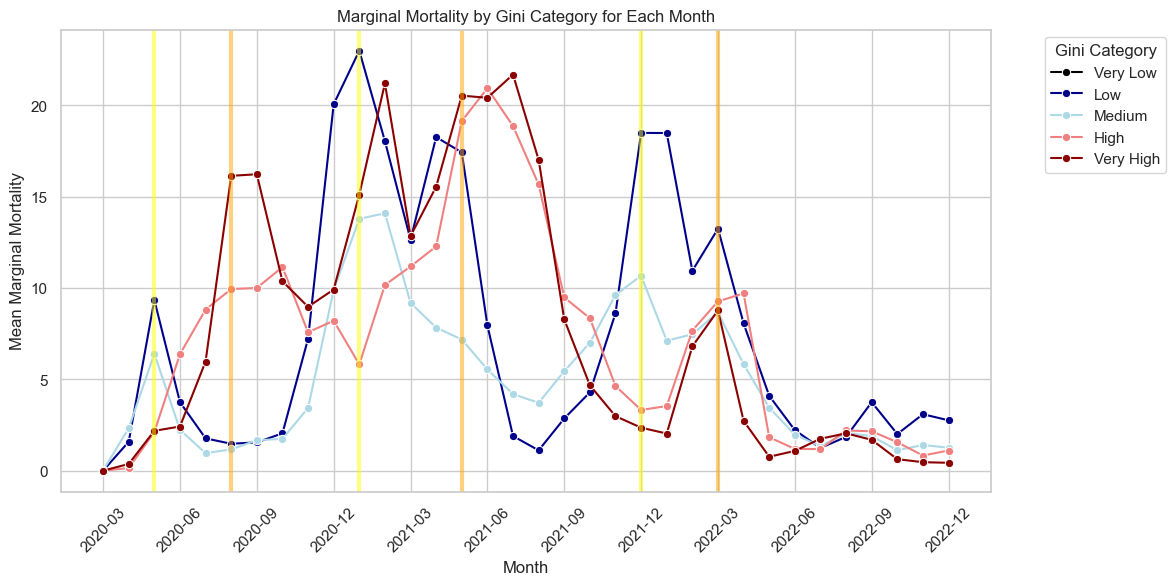

In [307]:
# Calculate the mean of Marginal Mortality for each quarter and Gini category
quarter_gini_mean = merged_data.groupby(['Month', 'Gini Category'], observed=False)['Marginal Mortality'].mean().reset_index()

# draw the line graph
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.lineplot(data=quarter_gini_mean, x='Month', y='Marginal Mortality', hue='Gini Category', 
             marker='o', palette=gini_colors)

plt.title("Marginal Mortality by Gini Category for Each Month")
plt.xlabel("Month")
plt.ylabel("Mean Marginal Mortality")

# set labels and the legend
all_labels = quarter_gini_mean['Month'].unique()
filtered_labels = all_labels[all_labels >= '2020-03'][::3]
plt.xticks(filtered_labels, rotation=45)  
plt.legend(title='Gini Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# mark the time of outbreaks for Low and Medium
for date in ['2020-05', '2021-01', '2021-12']:
    plt.axvline(x=date, color='yellow', alpha=0.5, linewidth=3)  

# mark the time of outbreaks for High and Very High
for date in ['2020-08', '2021-05', '2022-03']:
    plt.axvline(x=date, color='orange', alpha=0.5, linewidth=3)  

plt.show()

The line graph shows the Stringency Index over time by Gini category. Countries with higher Gini indices generally maintain higher stringency levels throughout, though the index decreases over time overall. Low and Medium Gini countries tend to tighten policies during outbreaks and relax them shortly after, while High and Very High Gini countries sustain stringent measures consistently.

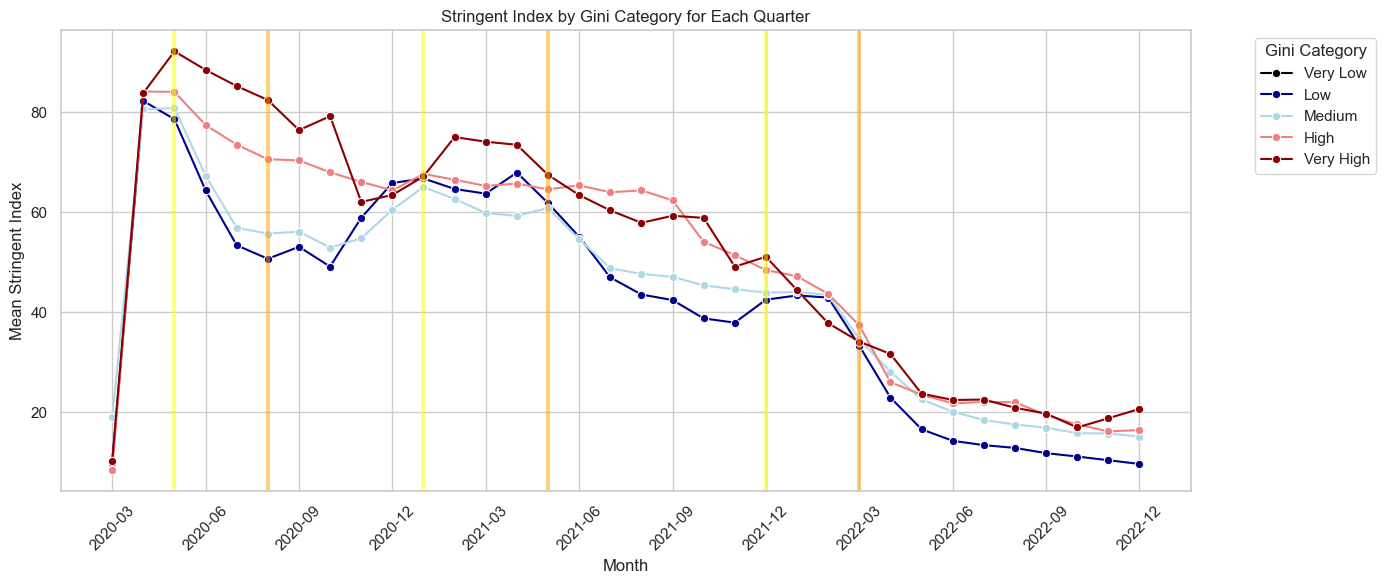

In [308]:
# Calculate the mean of the Stringent Index for each quarter and Gini category
quarter_gini_mean_stringent = merged_data.groupby(['Month', 'Gini Category'], observed=False)['Stringent Index'].mean().reset_index()

# draw the line graph
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

sns.lineplot(data=quarter_gini_mean_stringent, x='Month', y='Stringent Index', hue='Gini Category', 
             marker='o', palette=gini_colors)

# set labels and the legend
plt.title("Stringent Index by Gini Category for Each Quarter")
plt.xlabel("Month")
plt.ylabel("Mean Stringent Index")

filtered_labels = all_labels[all_labels >= '2020-03'][::3]
plt.xticks(filtered_labels, rotation=45) 
plt.legend(title='Gini Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# mark the time of outbreaks for Low and Medium
for date in ['2020-05', '2021-01', '2021-12']:
    plt.axvline(x=date, color='yellow', alpha=0.5, linewidth=3)  

# mark the time of outbreaks for High and Very High
for date in ['2020-08', '2021-05', '2022-03']:
    plt.axvline(x=date, color='orange', alpha=0.5, linewidth=3)  

plt.show()

From the graphs, we observe a reversal in the mortality trend during the third outbreak. Given that High and Very High consistently implement more stringent policies, we assume that these policies play a key role in driving this shift. This bar plot shows the means of marginal mortality by outbreak and Gini category. There is a significant decrease in mortality for Very High (about 80% decrease), followed by High (about 60% decrease). In contrast, Low only decreases by about 8%. This may be another piece of evidence for the assumption that **either consistently strict policies in high-inequality countries helped control the pandemic, or stringent measures are more effective in reducing COVID-19 mortality in high-inequality countries compared to low-inequality ones.**

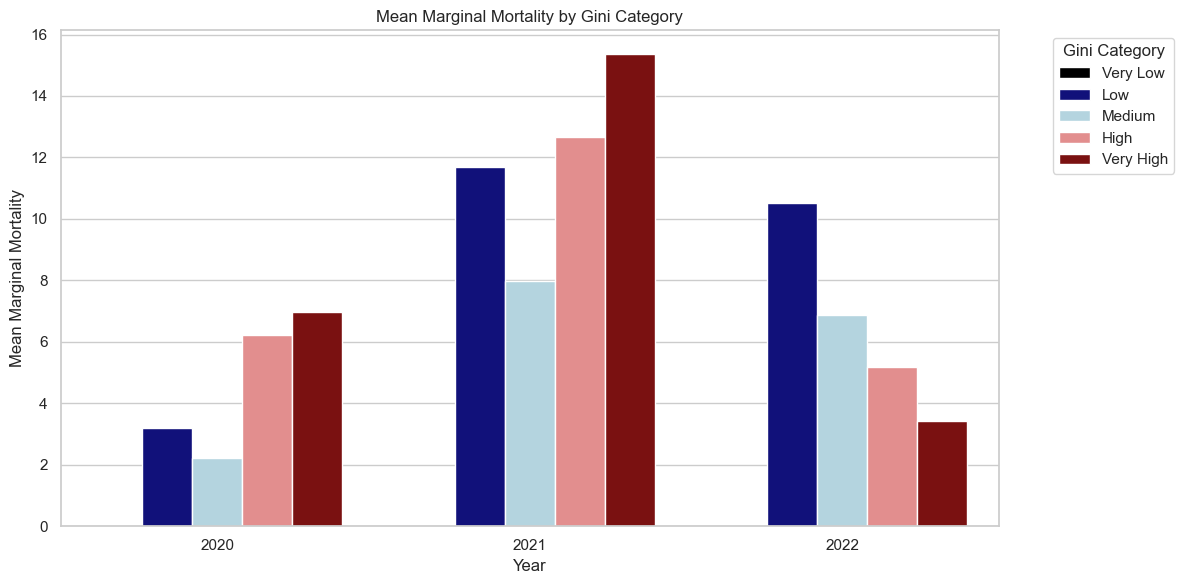

In [309]:
# preparing data
merged_data['Month'] = pd.to_datetime(merged_data['Month'])
time_ranges = {
    '2020': ('2020-03', '2020-11'),
    '2021': ('2020-12', '2021-10'),
    '2022': ('2021-11', '2022-06')
}
merged_data['Year'] = merged_data['Month'].apply(
    lambda x: next((year for year, (start, end) in time_ranges.items() if pd.to_datetime(start) <= x <= pd.to_datetime(end)), None))
merged_data_1 = merged_data.dropna(subset=['Year'])

# Calculate means of Marginal Mortality by outbreak and Gini Category Grouping
grouped_data = merged_data_1.groupby(['Year', 'Gini Category'], observed=False)['Marginal Mortality'].mean().reset_index()

# draw the bar plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.barplot(data=grouped_data, x='Year', y='Marginal Mortality', hue='Gini Category', palette=gini_colors)

# set labels and the legend
plt.title("Mean Marginal Mortality by Gini Category")
plt.xlabel("Year")
plt.ylabel("Mean Marginal Mortality")
plt.legend(title='Gini Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

The box plot shows hospital beds per 1,000 people by Gini category. Lower Gini countries have more beds, indicating better healthcare infrastructure. Very High Gini countries shows an increase, likely due to pandemic-driven investments in healthcare (Bambra et al., 2020).

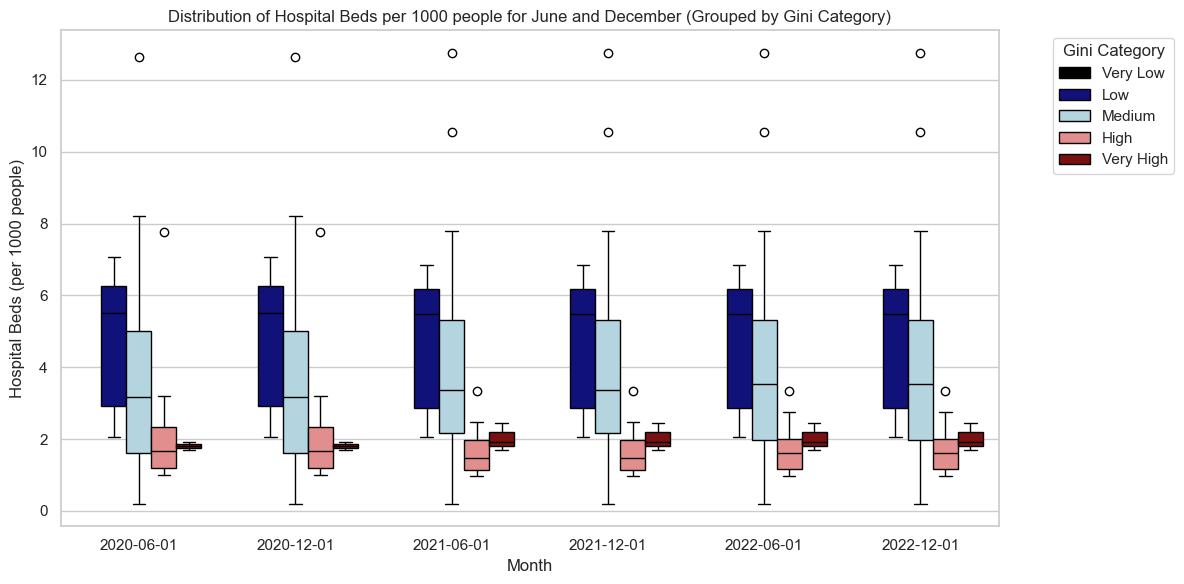

In [310]:
# prepare data
merged_data['Month_only'] = merged_data['Month'].dt.month
filtered_data = merged_data[merged_data['Month_only'].isin([6, 12])]

# draw the box plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.boxplot(x='Month', y='Hospital Beds', hue='Gini Category', data=filtered_data, palette=gini_colors)

# set labels and the legend
plt.title("Distribution of Hospital Beds per 1000 people for June and December (Grouped by Gini Category)")
plt.xlabel("Month")
plt.ylabel("Hospital Beds (per 1000 people)")
plt.legend(title='Gini Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

The scatter plots show the relationship between population density, GDP per capita and log Marginal mortality. They are randomly distributed without obvious scatters and trends, suggesting that these control variables may not have a significant relationship with the dependent variable. Therefore, I test models both with and without these variables to determine the most suitable regression.

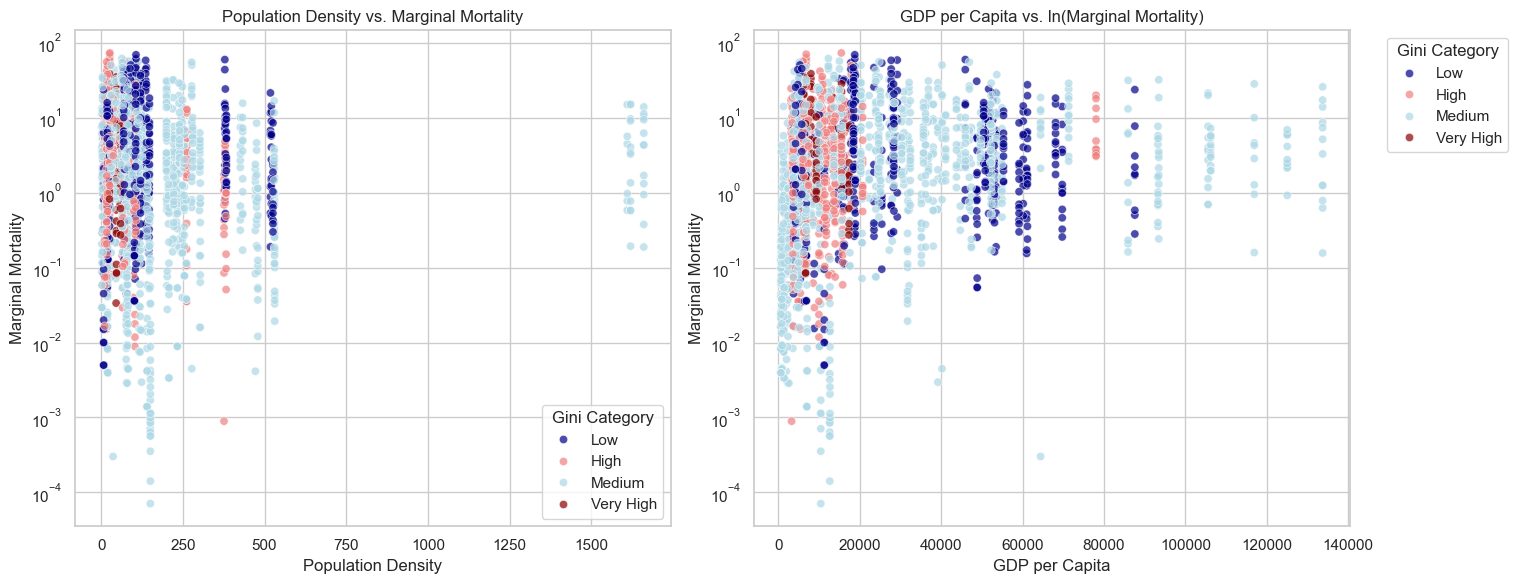

In [311]:
# draw the first plot: Population Density vs. Marginal Mortality
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  
sns.set(style="whitegrid")

merged_data['Gini Category'] = merged_data['Gini Category'].astype(str)

sns.scatterplot(
    ax=axes[0], 
    x='Population Density', 
    y='Marginal Mortality', 
    hue='Gini Category', 
    palette=gini_colors, 
    data=merged_data,
    alpha=0.7
)
axes[0].set_title("Population Density vs. Marginal Mortality")
axes[0].set_xlabel("Population Density")
axes[0].set_ylabel("Marginal Mortality")
axes[0].set_yscale("log")

# draw the second plot：GDP per Capita vs. Marginal Mortality
sns.scatterplot(
    ax=axes[1], 
    x='GDP per capita', 
    y='Marginal Mortality', 
    hue='Gini Category', 
    palette=gini_colors, 
    data=merged_data,
    alpha=0.7
)
axes[1].set_title("GDP per Capita vs. ln(Marginal Mortality)")
axes[1].set_xlabel("GDP per Capita")
axes[1].set_ylabel("Marginal Mortality")
axes[1].set_yscale("log")  

plt.tight_layout()
plt.legend(title='Gini Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Finally, we examine the correlation between independent variables. Most scatter plots appear randomly distributed, except for GDP per capita and hospital beds, which is fan-shaped. This suggests that multicollinearity is not a significant concern. However, I again test models with and without these variables to determine the most suitable regression. (Current word count 1289)

<Figure size 1000x800 with 0 Axes>

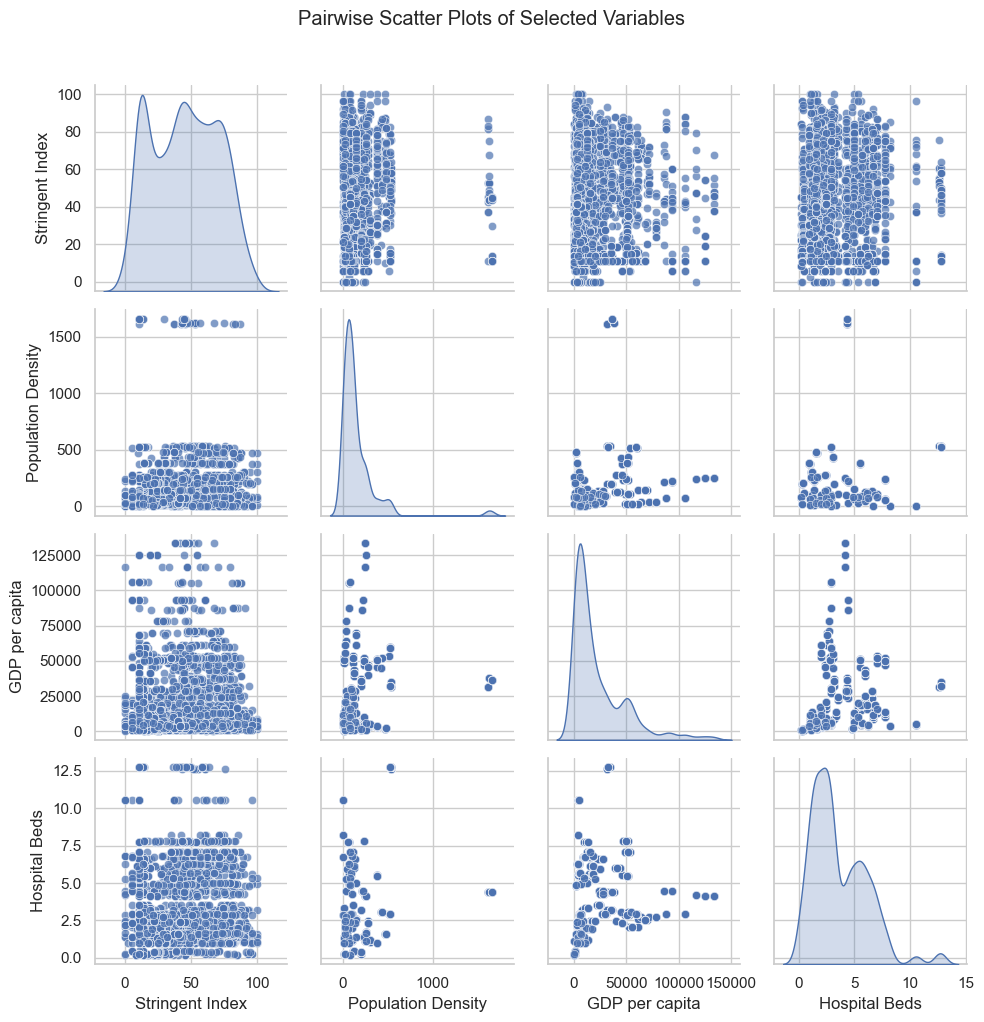

In [312]:
# draw x-x scatter plots
plt.figure(figsize=(10, 8))

variables = ['Gini Category', 'Stringent Index', 'Population Density', 'GDP per capita', 'Hospital Beds']

sns.pairplot(merged_data[variables], diag_kind='kde', plot_kws={'alpha': 0.7})

plt.suptitle("Pairwise Scatter Plots of Selected Variables", y=1.02)
plt.tight_layout()
plt.show()

# Project Two #

## The Message ##

**The Message:** Countries with higher Gini Index tend to have higher COVID-19 Mortality. One possible explanation for the reversed pattern during the third outbreak is that strict prevention policies have a better effect of reducing Mortality for countries with higher income inequality.

**Explanation:** The mortality rates in the Low and Medium Gini categories exceed those in the High and Very High categories during the third outbreak, which violates the literature finding (Sepulveda & Brooker, 2021). Since countries with High and Very High Gini indices tend to consistently implement more stringent policies (observed in the stringent index line graph), we assume that either these more stringent policies effectively reduce mortality, or that stringent prevention measures are more effective in mitigating COVID-19 mortality in countries with higher income inequality.

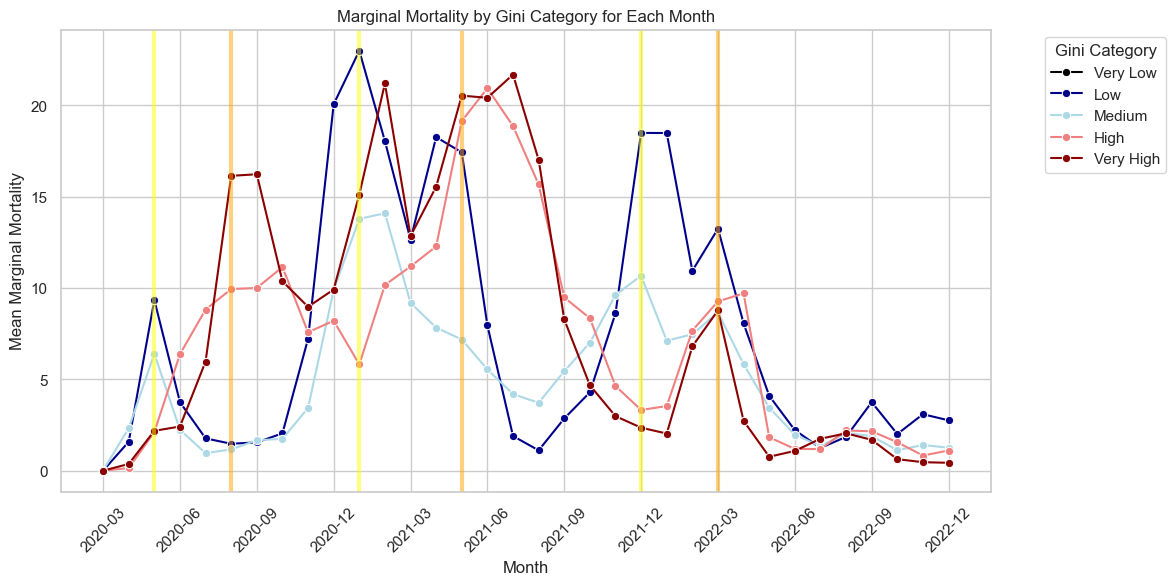

In [313]:
# draw the line graph
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.lineplot(data=quarter_gini_mean, x='Month', y='Marginal Mortality', hue='Gini Category', 
             marker='o', palette=gini_colors)

plt.title("Marginal Mortality by Gini Category for Each Month")
plt.xlabel("Month")
plt.ylabel("Mean Marginal Mortality")

# set labels and the legend
all_labels = quarter_gini_mean['Month'].unique()
filtered_labels = all_labels[all_labels >= '2020-03'][::3]
plt.xticks(filtered_labels, rotation=45)  
plt.legend(title='Gini Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# mark the time of outbreaks for Low and Medium
for date in ['2020-05', '2021-01', '2021-12']:
    plt.axvline(x=date, color='yellow', alpha=0.5, linewidth=3)  

# mark the time of outbreaks for High and Very High
for date in ['2020-08', '2021-05', '2022-03']:
    plt.axvline(x=date, color='orange', alpha=0.5, linewidth=3)  

plt.show()

## Maps and Interpretations ##

The map below shows the distribution of Gini Category. Generally, countries with Very High Gini indices are concentrated in northeastern South America, while those with High indices are mostly found in the Americas and parts of South Asia; Medium countries are found in Western and Southern Europe, Africa, and Asia; and Low countries are found in Central Asia, Northern Europe, and Central Europe, including Greenland. Overall, there is a geographical pattern in the distribution of Gini Categories, with the Eastern Hemisphere generally exhibiting lower Gini Index values compared to the Western Hemisphere.

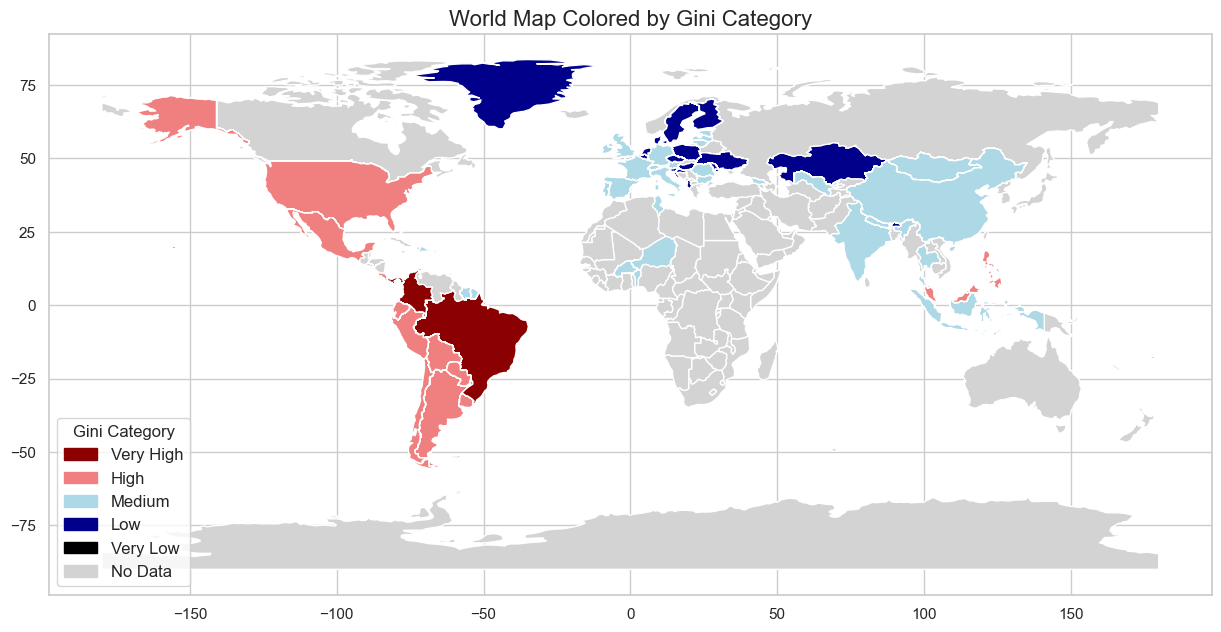

In [320]:
import geopandas as gpd
from matplotlib.patches import Patch

# add color lightgray for NAs
gini_colors = {
    'Very High': 'darkred',
    'High': 'lightcoral',
    'Medium': 'lightblue',
    'Low': 'darkblue',
    'Very Low': 'black',
    'No Data': 'lightgray'  
}

# load the map data and standardize the name of countries
world = gpd.read_file(r"C:\Users\chenr\OneDrive\ECO225Project\Data\map\ne_110m_admin_0_countries.shp")
world.replace({
    'United States of America': 'United States',
    'The Bahamas': 'Bahamas',
    'Gambia': 'Gambia, The',
    'Democratic Republic of the Congo': 'Congo (Kinshasa)',
    'Republic of the Congo': 'Congo (Brazzaville)',
    'East Timor': 'Timor-Leste'
}, inplace=True)

merged_world = world.merge(merged_data, left_on='SOVEREIGNT', right_on='Country Name', how='left')
merged_world['Gini Category'] = merged_world['Gini Category'].astype('category')
merged_world['Gini Category'] = merged_world['Gini Category'].cat.add_categories('No Data')
merged_world['Gini Category'] = merged_world['Gini Category'].fillna('No Data')
merged_world['color'] = merged_world['Gini Category'].map(gini_colors)

# draw the map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_world.plot(ax=ax, legend=False, color=merged_world['color'])

legend_labels = [Patch(color=gini_colors[key], label=key) for key in gini_colors]
ax.legend(handles=legend_labels, title='Gini Category', loc='lower left', fontsize=12)
ax.set_title('World Map Colored by Gini Category', fontsize=16)

plt.show()

The map shows average marginal mortality during the second and third outbreaks. A significant decline is observed in South America, North America, and South Asia, indicating reduced mortality in High and Very High Gini countries. In contrast, Northern and Central Europe, including Greenland, darkened, suggesting increased mortality in Low Gini countries. Medium Gini countries saw a moderate decline. This change aligns with earlier visualizations.

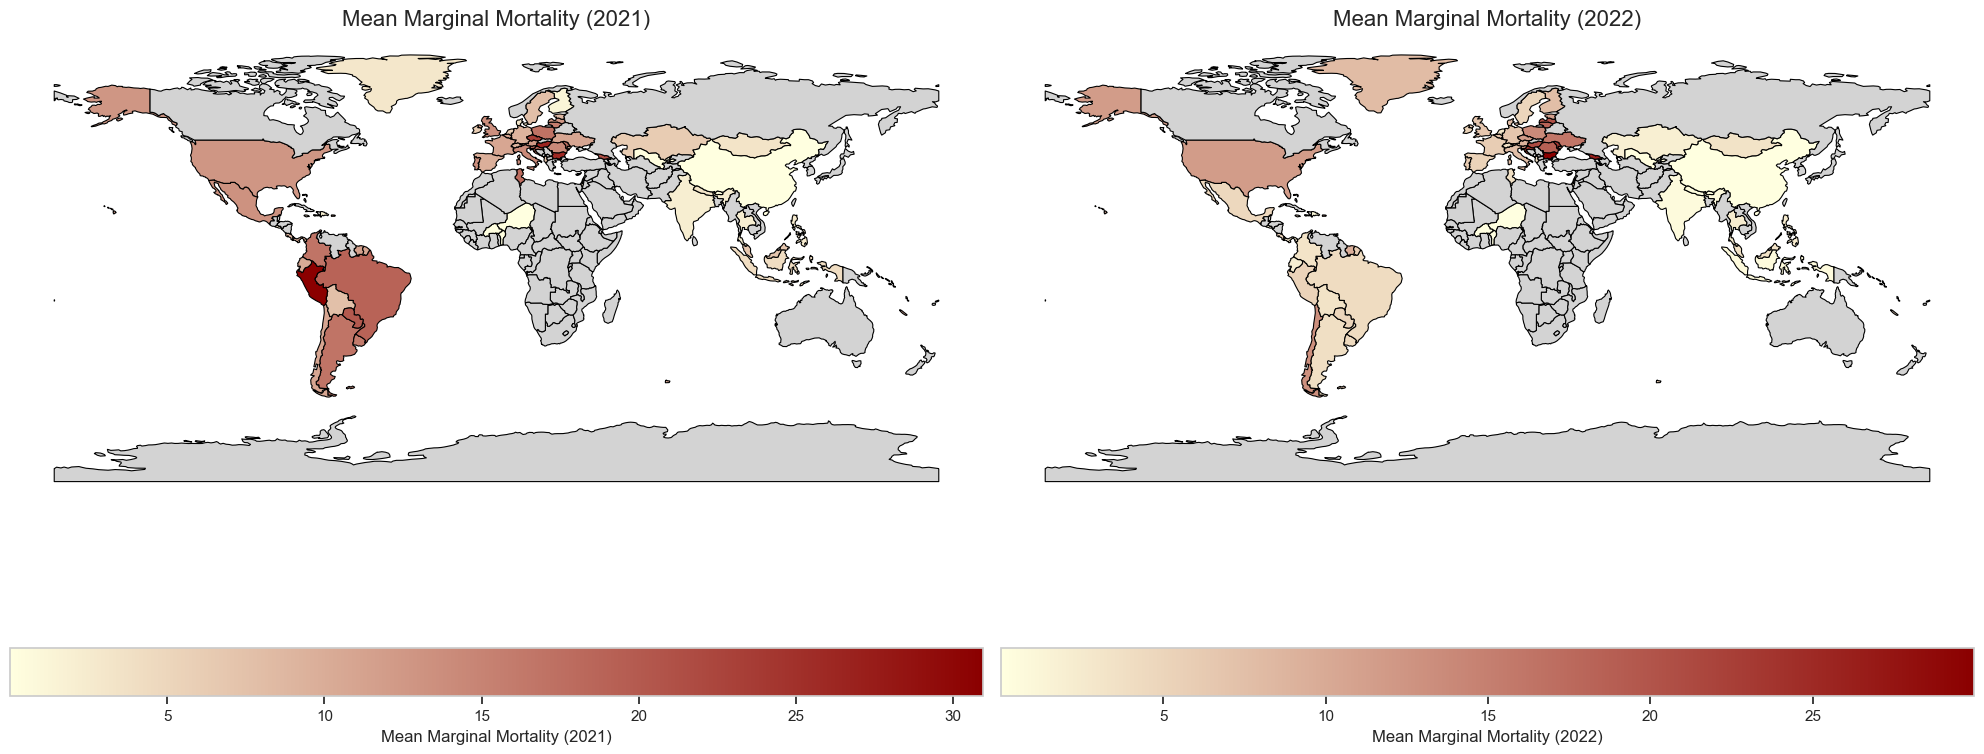

In [134]:
# set the time ranges
time_ranges = {
    '2021': ('2020-12', '2021-10'),
    '2022': ('2021-11', '2022-06')
}

# prepare data
filtered_data_2021 = merged_data[(merged_data['Month'] >= time_ranges['2021'][0]) & 
                                 (merged_data['Month'] <= time_ranges['2021'][1])]
filtered_data_2022 = merged_data[(merged_data['Month'] >= time_ranges['2022'][0]) & 
                                 (merged_data['Month'] <= time_ranges['2022'][1])]

mean_data_2021 = filtered_data_2021.groupby('Country Name', observed=False)['Marginal Mortality'].mean().reset_index()
mean_data_2022 = filtered_data_2022.groupby('Country Name', observed=False)['Marginal Mortality'].mean().reset_index()

merged_world_2021 = world.merge(mean_data_2021[['Country Name', 'Marginal Mortality']], 
                                left_on='SOVEREIGNT', right_on='Country Name', how='left')
merged_world_2022 = world.merge(mean_data_2022[['Country Name', 'Marginal Mortality']], 
                                left_on='SOVEREIGNT', right_on='Country Name', how='left')

# draw graphs
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

merged_world_2021.plot(column='Marginal Mortality', cmap=mortality_cmap, linewidth=0.8, edgecolor='black', 
                       legend=True, ax=axes[0],
                       legend_kwds={'label': "Mean Marginal Mortality (2021)", 'orientation': "horizontal"},
                       missing_kwds={"color": "lightgrey", "label": "No Data"})  
axes[0].set_title('Mean Marginal Mortality (2021)', fontsize=16)
axes[0].axis('off')  

merged_world_2022.plot(column='Marginal Mortality', cmap=mortality_cmap, linewidth=0.8, edgecolor='black', 
                       legend=True, ax=axes[1],
                       legend_kwds={'label': "Mean Marginal Mortality (2022)", 'orientation': "horizontal"},
                       missing_kwds={"color": "lightgrey", "label": "No Data"})  
axes[1].set_title('Mean Marginal Mortality (2022)', fontsize=16)
axes[1].axis('off')  

plt.tight_layout()
plt.show()

The map uses color to show changes in Marginal Mortality between the second and third outbreaks (blue for reduction, red for increase). Dot color and size represent the interaction term's strength (yellow for stronger, green for weaker). Yellow dots cluster in dark blue countries, while green dots appear in red, white, or light blue areas, suggesting a potential negative relationship between Marginal Mortality changes and the interaction of the Gini Index and Stringent Index. If confirmed through regression analysis, this would support the hypothesis that strict policies are more effective in reducing mortality in high-inequality countries. However, statistical analysis is needed for conclusive evidence.

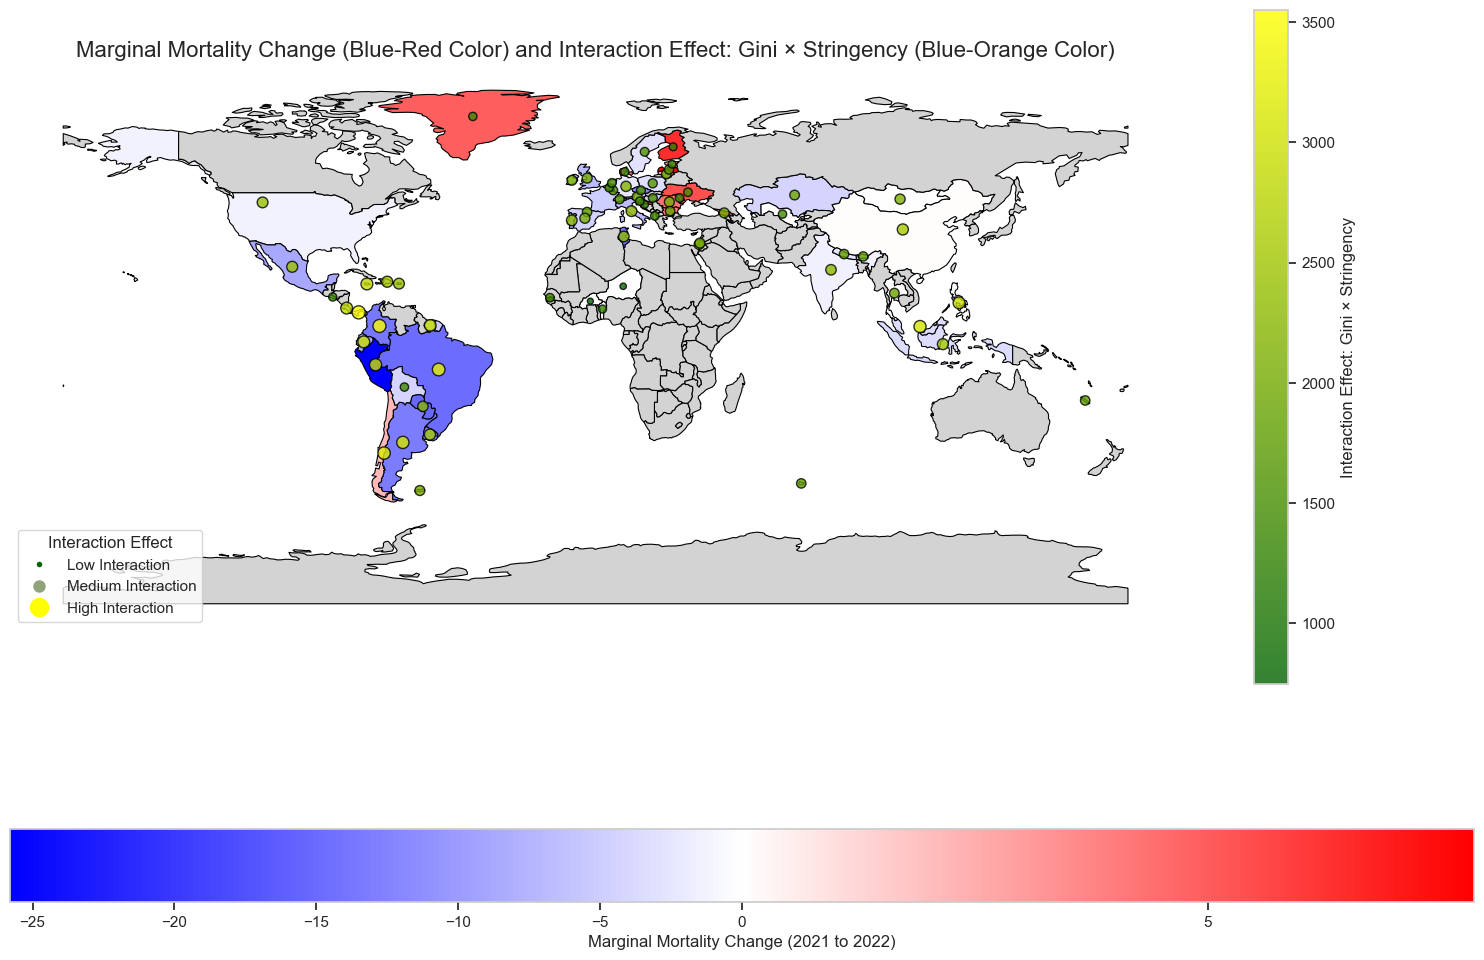

In [164]:
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# calculate Gini Index × Stringency Index and prepare data
merged_data["Gini_Stringency"] = merged_data["Gini Index"] * merged_data["Stringent Index"]
mean_data_2021 = filtered_data_2021.groupby('Country Name', observed=False).agg({
    'Marginal Mortality': 'mean',  
    'Gini_Stringency': 'mean'      
}).reset_index()
mean_data_2022 = filtered_data_2022.groupby('Country Name', observed=False).agg({
    'Marginal Mortality': 'mean',  
    'Gini_Stringency': 'mean'      
}).reset_index()

merged_world_2021 = world.merge(mean_data_2021[['Country Name', 'Marginal Mortality', 'Gini_Stringency']], 
                                left_on='SOVEREIGNT', right_on='Country Name', how='left')
merged_world_2022 = world.merge(mean_data_2022[['Country Name', 'Marginal Mortality', 'Gini_Stringency']], 
                                left_on='SOVEREIGNT', right_on='Country Name', how='left')
merged_world_2021['Marginal Mortality 2021'] = merged_world_2021['Marginal Mortality']
merged_world_2022['Marginal Mortality 2022'] = merged_world_2022['Marginal Mortality']
merged_world_change = world.merge(mean_data_2021[['Country Name', 'Marginal Mortality', 'Gini_Stringency']], 
                                 left_on='SOVEREIGNT', right_on='Country Name', how='left')
merged_world_change = merged_world_change.merge(mean_data_2022[['Country Name', 'Marginal Mortality', 'Gini_Stringency']], 
                                                left_on='SOVEREIGNT', right_on='Country Name', how='left', 
                                                suffixes=('_2021', '_2022'))

merged_world_change['Marginal Mortality Change'] = (
    merged_world_change['Marginal Mortality_2022'] - merged_world_change['Marginal Mortality_2021']
)

# set colors
change_cmap = LinearSegmentedColormap.from_list("change_cmap", ["blue", "white", "red"])
interaction_cmap = LinearSegmentedColormap.from_list("interaction_cmap", ["darkgreen", "yellow"])

norm = TwoSlopeNorm(vcenter=0)  

# draw the map whith color indicating change of Marginal Mortality
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_world_change.plot(column='Marginal Mortality Change', cmap=change_cmap, linewidth=0.8, 
                         edgecolor='black', legend=True, ax=ax, norm=norm,
                         legend_kwds={'label': "Marginal Mortality Change (2021 to 2022)", 'orientation': "horizontal"},
                         missing_kwds={"color": "lightgrey", "label": "No Data"})  

# draw scatter plot
merged_world_change['centroid'] = merged_world_change.geometry.centroid
scatter = ax.scatter(merged_world_change.centroid.x, merged_world_change.centroid.y, 
                     c=merged_world_change['Gini_Stringency_2021'],  
                     s=merged_world_change['Gini_Stringency_2021'] / 40,  
                     cmap=interaction_cmap, alpha=0.8, edgecolor='black')


cbar = plt.colorbar(scatter, ax=ax, label='Interaction Effect: Gini × Stringency')
ax.set_title("Marginal Mortality Change (Blue-Red Color) and Interaction Effect: Gini × Stringency (Blue-Orange Color)", fontsize=16)
ax.axis('off')  

legend_labels = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=5, label='Low Interaction'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#90A47C', markersize=10, label='Medium Interaction'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=15, label='High Interaction')
]
ax.legend(handles=legend_labels, title='Interaction Effect', loc='lower left')

plt.tight_layout()
plt.show()

## Regressions ##

<h3>Methodology<h3>

**Model Selection:**

The distribution of marginal deaths across countries follows a Negative Binomial pattern. After careful exploration of potential models, the Generalized Linear Model (GLM) with a Negative Binomial (NB) distribution is selected as the most appropriate method for modeling marginal mortality. This choice is driven by the nature of the dataset, which are consistent with the assumptions underlying the GLM NB model:

The dependent variable, Marginal Mortality, represents population-adjusted count data. Given the nature of the data, traditional linear regression models, such as Ordinary Least Squares (OLS), are unsuitable due to their assumption of a continuous and normally distributed dependent variable. Therefore, Poission and Negative binomial are more suitable.

Moreover, there is no excess zeros, indicating it is not necessary to use ZIP or ZINB.

Specifically, the dataset demonstrates overdispersion, where the variance exceeds the mean, which violates the assumptions of the Poisson distribution and makes the Negative Binomial model a more suitable choice.

**Model Specification:** 

The (Full) GLM Negative Binomial model is specified as follows:

$$
\begin{aligned}
\log(\text{E[Marginal Death]})_{it} &= \alpha_i + \beta_1 (\text{Gini Index})_{it} + \beta_2 (\text{Stringent Index})_{it} + \beta_3 (\text{Gini Index} \times \text{Stringent Index})_{it} \\
&+ \beta_4 (\text{Population Density})_{it} + \beta_5 (\text{GDP per capita})_{it} + \beta_6 (\text{Hospital Beds})_{it} \\
&+ \log(\text{Population})_{it} \quad (\text{Offset}) \\
&+ (\text{Country})_i + (\text{Year})_t
\end{aligned}
$$

**Dependent Variable**  
- $ \log(\mathbb{E}[\text{Marginal Death}])_{it} $: The expected value of the monthly marginal mortality death number in country $ i $ in year $ t $.

**Independent Variables**  

- **Gini Index**  
  - $ \text{Gini Index}_{it} $: A measure of income inequality in country $ i $ in year $ t $.

- **Stringent Index**  
  - $ \text{Stringent Index}_{it} $: A measure of the strictness of government policies in country $ i $ in year $ t $.

- **Gini Index × Stringent Index**  
  - $ \text{Gini Index}_{it} \times \text{Stringent Index}_{it} $: An interaction term to examine whether the effect of policy stringency on marginal mortality varies by income inequality.

- **Population Density**  
  - $ \text{Population Density}_{it} $: The population per unit area in country $ i $ in year $ t $.

- **GDP per capita**  
  - $ \text{GDP per capita}_{it} $: The gross domestic product per capita in country $ i $ in year $ t $.

- **Hospital Beds**  
  - $ \text{Hospital Beds}_{it} $: The number of hospital beds per capita in country $ i $ in year $ t $.

**Offset Term**  

- **Population (log-transformed)**  
  - $ \log(\text{Population})_{it} $: The natural logarithm of the population in country $ i $ in year $ t $, included as an offset to control for population size.

**Fixed Effects**  

- **Country Fixed Effects**  
  - $ (\text{Country})_i $: Country fixed effects to control for time-invariant country-specific characteristics.

- **Year Fixed Effects**  
  - $ (\text{Year})_t $: Year fixed effects to account for time-specific unobserved heterogeneity.

Since we can move the population offset term to the left side of the function, the left hand side becomes to:

$$
\log(\text{E[Marginal Death]}) - \log(\text{Population}) = 
\log\left(\frac{\text{E[Marginal Death]}}{\text{Population}}\right) =
\log(\text{E[Marginal Mortality]})
$$


Therefore, eventhough Marginal Mortality is a ratio, we can still apply GLM NB since it is simply the combination of a count data and its offset. The final full model is: 

$$
\begin{aligned}
\log(\text{E[Marginal Mortality]})_{it} &= \alpha_i + \beta_1 (\text{Gini Index})_{it} + \beta_2 (\text{Stringent Index})_{it} + \beta_3 (\text{Gini Index} \times \text{Stringent Index})_{it} \\
&+ \beta_4 (\text{Population Density})_{it} + \beta_5 (\text{GDP per capita})_{it} + \beta_6 (\text{Hospital Beds})_{it} \\
&+ (\text{Country})_i + (\text{Year})_t
\end{aligned}
$$

<h3>Fit Regression Models<h3>

First, we directly use the Gini Index (instead of the Gini Category) as a continuous variable in our regressions. Across the six models in each group, variables are gradually added in the following sequence: starting with the key variable of interest, then the interaction term, and finally the control variables.

**First Comparison: Models with only year fixed effects VS Models with both year and country fixed effects**

Considering that adding country fixed effects may absorb the significance of our main variables, we first compare two groups of regressions: one with only year fixed effects and the other with both year and country fixed effects. 

The first goup shows models with only year fixed effects

In [143]:
#!pip install stargazer
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import HTML
from statsmodels.genmod.families import NegativeBinomial

# Remove duplicate columns if any
merged_data_1 = merged_data.loc[:, ~merged_data.columns.duplicated()]

# Ensure we have a constant term for GLM
merged_data_1['const'] = 1

# Ensure Marginal Mortality has no zero or negative values
merged_data_1['Marginal Mortality'] = merged_data_1['Marginal Mortality'].apply(lambda x: x if x > 0 else 0.00001)
merged_data_1.columns = merged_data_1.columns.str.replace(' ', '_')

# define the regressions
formula_1 = "Marginal_Mortality ~ Gini_Index + C(year)"
formula_2 = "Marginal_Mortality ~ Gini_Index + Stringent_Index + C(year)"
formula_3 = "Marginal_Mortality ~ Gini_Index + Stringent_Index + Stringent_Index:Gini_Index + C(year)"
formula_4 = "Marginal_Mortality ~ Gini_Index + Stringent_Index + Stringent_Index:Gini_Index + GDP_per_capita + C(year)"
formula_5 = "Marginal_Mortality ~ Gini_Index + Stringent_Index + Stringent_Index:Gini_Index + GDP_per_capita + Population_Density + C(year)"
formula_6 = "Marginal_Mortality ~ Gini_Index + Stringent_Index + Stringent_Index:Gini_Index + GDP_per_capita + Population_Density + Hospital_Beds + C(year)"

family = NegativeBinomial(alpha=alpha)

reg1 = smf.glm(formula_1, data=merged_data_1, family=family).fit()
reg2 = smf.glm(formula_2, data=merged_data_1, family=family).fit()
reg3 = smf.glm(formula_3, data=merged_data_1, family=family).fit()
reg4 = smf.glm(formula_4, data=merged_data_1, family=family).fit()
reg5 = smf.glm(formula_5, data=merged_data_1, family=family).fit()
reg6 = smf.glm(formula_6, data=merged_data_1, family=family).fit()

stargazer = Stargazer([reg1, reg2, reg3, reg4, reg5, reg6])
stargazer.title("GLM Negative Binomial Regression Results with Time Fixed Effects")
stargazer.custom_columns(["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"], [1, 1, 1, 1, 1, 1])

html_output = stargazer.render_html()

import re
html_output_cleaned = re.sub(r'<tr>.*?C\(year\).*?</tr>', '', html_output, flags=re.DOTALL)

HTML(html_output_cleaned)

,(0.062),(0.086),(0.086),(0.086),(0.086),(0.087)
GDP_per_capita,,,,0.000***,0.000***,0.000***
,,,,(0.000),(0.000),(0.000)
Gini_Index,-0.001,-0.009**,-0.034***,-0.032***,-0.034***,-0.009
,(0.004),(0.004),(0.009),(0.009),(0.009),(0.009)
Hospital_Beds,,,,,,0.150***
,,,,,,(0.011)
Intercept,1.657***,-0.081,0.789**,0.629**,0.773**,-0.734**
,(0.134),(0.155),(0.308),(0.317),(0.317),(0.336)
Population_Density,,,,,-0.001***,-0.001***
,,,,,(0.000),(0.000)


In [144]:
# Model features
def extract_stats(model):
    stats = {  
        "Log-Likelihood": model.llf,  
        "Deviance": model.deviance,  
        "Pseudo R-squ. (CS)": model.pseudo_rsquared(kind='cs')  
    }
    return stats

stats_list = [extract_stats(model) for model in [reg1, reg2, reg3, reg4, reg5, reg6]]
df = pd.DataFrame(stats_list)
df.index = ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"]
df = df.T

display(df)

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6
Log-Likelihood,-6013.023949,-5841.025018,-5836.207932,-5833.094686,-5812.917499,-5747.890545
Deviance,3185.297940,2841.300079,2831.665906,2825.439415,2785.085041,2655.031133
Pseudo R-squ. (CS),0.113640,0.249470,0.252958,0.255204,0.269597,0.314116


These statistical values measures how well the model fits the data. They can help us pick a model: 

- **Log-Likelihood**: Larger values (closer to 0) indicate that the model fits the data better.

- **Deviance**: Calculated based on log-likelihood values. The smaller the deviation, the better the model fits the data.

- **Pseudo R-squ. (CS)**: Pseudo R-square is used in GLMs, similar to R-square in linear regression. It takes values in the range [0, 1], with larger values indicating more variation explained by the model.

Based on these standards, Model 6 is the current best model.

Next, we add country fixed effects.

In [153]:
# rdefine the regressions
formula_1 = "Marginal_Mortality ~ Gini_Index + C(year) + C(Country_Name)"
formula_2 = "Marginal_Mortality ~ Gini_Index + Stringent_Index + C(year) + C(Country_Name)"
formula_3 = "Marginal_Mortality ~ Gini_Index + Stringent_Index + Stringent_Index:Gini_Index + C(year) + C(Country_Name)"
formula_4 = "Marginal_Mortality ~ Gini_Index + Stringent_Index + Stringent_Index:Gini_Index + GDP_per_capita + C(year) + C(Country_Name)"
formula_5 = "Marginal_Mortality ~ Gini_Index + Stringent_Index + Stringent_Index:Gini_Index + GDP_per_capita + Population_Density + C(year) + C(Country_Name)"
formula_6 = "Marginal_Mortality ~ Gini_Index + Stringent_Index + Stringent_Index:Gini_Index + GDP_per_capita + Population_Density + Hospital_Beds + C(year) + C(Country_Name)"

family = NegativeBinomial(alpha=alpha)

reg7 = smf.glm(formula_1, data=merged_data_1, family=family).fit()
reg8 = smf.glm(formula_2, data=merged_data_1, family=family).fit()
reg9 = smf.glm(formula_3, data=merged_data_1, family=family).fit()
reg10 = smf.glm(formula_4, data=merged_data_1, family=family).fit()
reg11 = smf.glm(formula_5, data=merged_data_1, family=family).fit()
reg12 = smf.glm(formula_6, data=merged_data_1, family=family).fit()

stargazer = Stargazer([reg7, reg8, reg9, reg10, reg11, reg12])
stargazer.title("GLM Negative Binomial Regression Results with Time Fixed Effects")
stargazer.custom_columns(["Model 7", "Model 8", "Model 9", "Model 10", "Model 11", "Model 12"], [1, 1, 1, 1, 1, 1])

html_output = stargazer.render_html()

import re
html_output_cleaned = re.sub(r'<tr>.*?C\(year\).*?</tr>', '', html_output, flags=re.DOTALL)

HTML(html_output_cleaned)

,(0.067),(0.101),(0.101),(0.115),(0.115),(0.116)
GDP_per_capita,,,,-0.000***,-0.000***,-0.000***
,,,,(0.000),(0.000),(0.000)
Gini_Index,0.126***,0.074*,0.058,0.094*,0.094*,0.084*
,(0.044),(0.045),(0.047),(0.048),(0.048),(0.049)
Hospital_Beds,,,,,,1.651
,,,,,,(1.529)
Intercept,-2.713**,-3.411**,-2.903**,-3.634**,-3.232*,-7.820*
,(1.327),(1.336),(1.423),(1.439),(1.685),(4.583)
Population_Density,,,,,-0.004,-0.003
,,,,,(0.009),(0.009)


In [154]:
# Model features
def extract_stats(model):
    stats = { 
        "Log-Likelihood": model.llf,  
        "Deviance": model.deviance,  
        "Pseudo R-squ. (CS)": model.pseudo_rsquared(kind='cs')  
    }
    return stats

stats_list = [extract_stats(model) for model in [reg7, reg8, reg9, reg10, reg11, reg12]]
df = pd.DataFrame(stats_list)
df.index = ["Model 7", "Model 8", "Model 9", "Model 10", "Model 11", "Model 12"]
df = df.T

display(df)

,Model 7,Model 8,Model 9,Model 10,Model 11,Model 12
Log-Likelihood,-5437.934448,-5263.054485,-5262.658658,-5250.782548,-5250.675746,-5250.126589
Deviance,2035.118939,1685.359012,1684.567358,1660.815138,1660.601535,1659.503220
Pseudo R-squ. (CS),0.491765,0.570847,0.571011,0.575910,0.575954,0.576179


Similarly, model 12 is the best fit based on statistical standards and better than model 6. Moreover, it makes perfect sense to add state fixed effects. Country fixed effects are used to capture unobserved factors that are specific to each country and do not change over time. These differences may influence COVID-19 mortality. By adding it, the accuracy of models can be improved. Additionally, the effect of my key variables is not entirely absorbed by country fixed effects in group 2. Therefore, all things considered, it is optimal to include country fixed effects.

Next, we interpret the betas of model 12: 

Because the coefficients of a negative binomial regression represent changes on a logarithmic scale, we need to exponentiate the coefficients in order to interpret their practical significance.

$Expected Count = e^{\beta}$

- If β > 0, then $e^{\beta} > 1$, indicating that holding everything else constant, for each unit increase in the independent variable, the expected value of the dependent variable increases by $e^{\beta}$ times.

- If β < 0, then $e^{\beta} < 1$, indicating that holding everything else constant,  for each unit increase in the independent variable, the expected value of the dependent variable decreases by $e^{\beta}$ times.

- **Gini Index**  
  - The coefficient is **positive and significant**, indicating that income inequality is possitively related to COVID-19 mortality. For each **1%** unit increase in the Gini coefficient, the expected value of COVID-19 mortality increases by a factor of 1.084/100 (about 0.084%).
- **Stringent Index**  
  - The coefficient is positive and significant, indicating that the stringency of the prevention policy is possitively related to COVID-19 mortality. For every unit increase in the index of strictness of prevention policies, the expected value of COVID-19 mortality increased by 1.029 times (approximately 2.9%).
- **Gini Index × Stringent Index**  
  - The coefficient is small (0.000) and the interaction term is not significant, suggesting that the stringency of policies does not have a significant moderating effect on the relationship between income inequality and COVID-19 mortality.

Overall, income inequality is significantly and positively associated with COVID-19 mortality, which is consistent with the findings in the literature review. In addition, the strictness of prevention policies is significantly and positively associated with COVID-19 mortality, which is because countries implement stricter prevention and control policies when epidemics are severe, and does not suggest that it is the cause of increased mortality. Finally, the results indicate that the stringency of prevention policies does not significantly moderate the relationship between income inequality and COVID-19 mortality. This contradicts our earlier hypothesis that stringent policies are more effective in reducing mortality in high-inequality countries. Instead, the sharp decline in mortality in high-inequality countries during the third outbreak is likely due to their consistent  strict policies.

**Second Comparison: Models with Gini Index VS Models with Gini Category**

Since the goal of my research is to suggest pandemic prevention policies for countries with various levels of income inequality, I am more interested in whether strict prevention policies will have a higher mortality suppression effect for countries with certain level of income inequality. Therefore, the following set of models replace the Gini Index with the Gini Category to study the differences between groups. k represents different Gini Category (Low, Medium, High, Very High)

$$
\begin{aligned}
\log(\text{E[Marginal Mortality]})_{it} &= \alpha_i + \sum_{k=1}^K \beta_{1k} (\text{Gini Category}_{k})_{it} + \beta_2 (\text{Stringent Index})_{it} \\
&+ \sum_{k=1}^K \beta_{3k} (\text{Gini Category}_{k} \times \text{Stringent Index})_{it} \\
&+ \beta_4 (\text{Population Density})_{it} + \beta_5 (\text{GDP per capita})_{it} + \beta_6 (\text{Hospital Beds})_{it} \\
&+ (\text{Country})_i + (\text{Year})_t
\end{aligned}
$$

Set 'High' as the baseline.

In [ ]:
# Create dummy variables for 'Gini Category'
gini_dummies = pd.get_dummies(merged_data['Gini Category'], drop_first=True)  
gini_dummies = gini_dummies.astype(int)  

# Concatenate with the original DataFrame
merged_data = pd.concat([merged_data, gini_dummies], axis=1)

# Handle missing and infinite values
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert inf to NaN
merged_data.dropna(inplace=True)  # Drop rows with NaN

In [151]:
# refit models with Gini Category
formula_1 = "Marginal_Mortality ~ Low + Medium + Very_High + C(year) + C(Country_Name)"
formula_2 = "Marginal_Mortality ~ Low + Medium + Very_High + Stringent_Index + C(year) + C(Country_Name)"
formula_3 = "Marginal_Mortality ~ Low + Medium + Very_High + Stringent_Index + Stringent_Index * Very_High + Stringent_Index * Medium + Stringent_Index * Low + C(year) + C(Country_Name)"
formula_4 = "Marginal_Mortality ~ Low + Medium + Very_High + Stringent_Index + Stringent_Index * Very_High + Stringent_Index * Medium + Stringent_Index * Low + GDP_per_capita + C(year) + C(Country_Name)"
formula_5 = "Marginal_Mortality ~ Low + Medium + Very_High + Stringent_Index + Stringent_Index * Very_High + Stringent_Index * Medium + Stringent_Index * Low + GDP_per_capita + Population_Density + C(year) + C(Country_Name)"
formula_6 = "Marginal_Mortality ~ Low + Medium + Very_High + Stringent_Index + Stringent_Index * Very_High + Stringent_Index * Medium + Stringent_Index * Low + GDP_per_capita + Population_Density + Hospital_Beds + C(year) + C(Country_Name)"

family = NegativeBinomial(alpha=alpha)

reg13 = smf.glm(formula_1, data=merged_data_1, family=family).fit()
reg14 = smf.glm(formula_2, data=merged_data_1, family=family).fit()
reg15 = smf.glm(formula_3, data=merged_data_1, family=family).fit()
reg16 = smf.glm(formula_4, data=merged_data_1, family=family).fit()
reg17 = smf.glm(formula_5, data=merged_data_1, family=family).fit()
reg18 = smf.glm(formula_6, data=merged_data_1, family=family).fit()

# Show the outcomes
stargazer = Stargazer([reg13, reg14, reg15, reg16, reg17, reg18])
stargazer.title("GLM Negative Binomial Regression Results with Time and Country Fixed Effects")
stargazer.custom_columns(["Model 13", "Model 14", "Model 15", "Model 16", "Model 17", "Model 18"], [1, 1, 1, 1, 1, 1])

html_output = stargazer.render_html()

# remove all the year and time fixed effects from the table
import re
html_output_cleaned = re.sub(r'<tr>.*?C\(year\).*?</tr>', '', html_output, flags=re.DOTALL)

HTML(html_output_cleaned)

,(0.067),(0.102),(0.102),(0.116),(0.117),(0.118)
GDP_per_capita,,,,-0.000***,-0.000***,-0.000***
,,,,(0.000),(0.000),(0.000)
Hospital_Beds,,,,,,2.084
,,,,,,(1.522)
Intercept,0.747,-1.335***,-1.261**,0.126,0.587,-5.639
,(0.466),(0.494),(0.506),(0.592),(1.083),(4.693)
Low,0.263,0.091,-0.080,-1.114**,-1.114**,-1.044**
,(0.415),(0.427),(0.461),(0.519),(0.519),(0.522)
Medium,0.192,0.120,0.129,-0.315,-0.307,-0.269
,(0.281),(0.284),(0.310),(0.319),(0.320),(0.320)


In [152]:
# Model features
def extract_stats(model):
    stats = { 
        "Log-Likelihood": model.llf,  
        "Deviance": model.deviance,  
        "Pseudo R-squ. (CS)": model.pseudo_rsquared(kind='cs')  
    }
    return stats

stats_list = [extract_stats(model) for model in [reg13, reg14, reg15, reg16, reg17, reg18]]
df = pd.DataFrame(stats_list)
df.index = ["Model 13", "Model 14", "Model 15", "Model 16", "Model 17", "Model 18"]
df = df.T

display(df)

,Model 13,Model 14,Model 15,Model 16,Model 17,Model 18
Log-Likelihood,-5441.386109,-5263.752275,-5259.943776,-5247.591176,-5247.449810,-5246.539784
Deviance,2042.022261,1686.754593,1679.137595,1654.432394,1654.149662,1652.329610
Pseudo R-squ. (CS),0.490066,0.570557,0.572136,0.577217,0.577275,0.577646


Again, statistically, Model 18 (full model) is the best model. We now interpret its coefficients.

- **Intercept (High)**
  - Since we set High as the baseline, the intercept should represent the relation between countries with High Gini index and COVID-19 mortality when other variables are 0. However, it is unrealistic for variables (such as popolation densenty) to be zero. Therefore, the Intercept is meaningless and only serves as a standard to compare with other groups.
- **Low**  
  - COVID-19 mortality is significantly lower in low-income inequality countries compared to High. The mortality expectation for low-income inequality countries is lower than that for high-income inequality countries by 0.352 time (about 64.8% lower).
- **Medium**  
  - COVID-19 mortality is slightly lower (negative beta) but not significantly different in middle income inequality countries compared with High.
- **Very High**  
  - COVID-19 mortality is significantly lower in countries with very high income inequality compared to High. The mortality expectation for Very High  is 0.239 times that of High (about 76.1% Lower).
- **Stringent Index**  
  - The coefficient is positive and significant, indicating that the stringency of the prevention policy is possitively related to COVID-19 mortality. For every unit increase in the index of strictness of prevention and control policies, the expected value of COVID-19 mortality increased by 1.035 times (about 3.5% higher).
- **Low × Stringent Index**  
  - The coefficient is small (0.003) and not statistically significant, suggesting that the stringent prevention policies are not more effective for countries with low income inequality compared to High in controling COVID-19 death.
- **Medium × Stringent Index**  
  - The coefficient is small (-0.000) and not statistically significant, same as above.
- **Very High × Stringent Index**  
  - The coefficient is relatively **large (0.015) and statistically significant**. Holding everything else constant, for each unit increase in the strictness of prevention policies index, the expected value of mortality in very high income inequality countries increases by 1.015 times (i.e., an increase of about 1.5%) compare to high.

Overall, low income inequality has lower COVID-19 mortality than high-income inequality, which is consistent with the findings in literature review. However, very high income inequality is also associated with lower COVID-19 mortality. This may result from the reduced model fit caused by replacing the continuous Gini Index with the Gini Category. Thus, **the model using the Gini Index (Model 12) is more reliable in explaining the relationship between income inequality and COVID-19 mortality**.

Additionally, the stringency of prevention policies is significantly and positively associated with COVID-19 mortality. This aligns with the findings of previous models.

Finally, strict prevention policies have a weaker effect in reducing mortality in countries with very high income inequality, **which contradicts our hypothesis**. Through further literature review, I discovered several possible explanations: 
- Income inequality may exacerbate health inequalities, thereby affecting the effectiveness of public health policies (Pickett & Wilkinson, 2015).
- Income inequality can undermine the effectiveness of public health policies, especially if resources are unevenly distributed (Marmot, 2020).

Since beta is statistically significant and aligns more closely with the research objectives, **the model using the Gini Category (Model 18) is more plausible in explaining the moderating effect on the relationship between income inequality and COVID-19 mortality**. Moreover, both models suggest the decline in mortality in very high inequality countries during the third outbreak is likely due to their consistent strict policies. Hence, the initial assumption does not hold.

In summary, model 12 and model 18 are each appropriate for answering part of the research question and should be analyzed together. However, if one has to be chosen, model 18 is the most appropriate as it is more suitable for explaining the research question.

## Conclusion ##

Through statistical analysis, we find that higher income inequality correlates with higher COVID-19 mortality, and strict prevention policies are less effective in reducing mortality in very high inequality countries. This contradicts the initial hypothesis. This may due to lower policy implementation efficiency in such countries. However, visualizations and maps suggest that consistently strict policies have significantly benefited high inequality countries. Thus, despite smaller benefits compared to more equal nations, maintaining a certain level of strict policies is neccessary to protect public well-being in highly unequal countries. 

Next, I will refine the regression with additional controls and apply machine learning to validate these findings. (2994 words)

## Citations ##

[1] Furceri, D., Loungani, P., & Ostry, J. D. (2021). COVID-19 and inequality: The role of fiscal policy. International Monetary Fund. https://doi.org/10.5089/9781513576644.001

[2] Sepulveda, J., & Brooker, A. (2021). The impact of income inequality on pandemic response and recovery: A global perspective. Journal of Global Health, 11(2), 205-220. https://doi.org/10.7189/jogh.11.020220

[3] Chu, D. K., Akl, E. A., Duda, S., Solo, K., Yaacoub, S., & Schünemann, H. J. (2020). Physical distancing, face masks, and eye protection to prevent person-to-person transmission of SARS-CoV-2 and COVID-19: A systematic review and meta-analysis. The Lancet, 395(10242), 1973-1987. https://doi.org/10.1016/S0140-6736(20)31142-9

[4] Baker, M. G., Wilson, N., & Anglemyer, A. (2020). In search of the silver lining: The impact of COVID-19 elimination strategies on other health outcomes. The Lancet Public Health, 5(11), e611–e612. https://doi.org/10.1016/S2468-2667(20)30253-0

[5] Hale, T., Angrist, N., Goldszmidt, R., Kira, B., Petherick, A., Phillips, T., Webster, S., & Cameron-Blake, E. (2021). A global panel database of pandemic policies (Oxford COVID-19 Government Response Tracker). Nature Human Behaviour, 5(4), 529-538. https://doi.org/10.1038/s41562-021-01079-8

[6] Motallebi, S., Cheung, R. C. Y., Mohit, B., Shahabi, S., Tabriz, A. A., Sadeghi, B., & Moattari, S. (2021). Modeling COVID-19 Mortality Across 44 Countries: Face Covering May Reduce Deaths. American Journal of Preventive Medicine. https://doi.org/10.1016/j.amepre.2021.09.019

[7] Kissler, S. M., Tedijanto, C., Goldstein, E., Grad, Y. H., & Lipsitch, M. (2020). Projecting the transmission dynamics of SARS-CoV-2 through the postpandemic period. Science, 368(6493), 860–868. https://doi.org/10.1126/science.abb5793

[8] Sajadi, M. M., Habibzadeh, P., Vintzileos, A., Shokouhi, S., Miralles-Wilhelm, F., & Amoroso, A. (2020). Temperature, humidity, and latitude analysis to estimate potential spread and seasonality of coronavirus disease 2019 (COVID-19). JAMA Network Open, 3(6), e2011834. https://doi.org/10.1001/jamanetworkopen.2020.11834

[9] World Health Organization. (2021). COVID-19 weekly epidemiological update. https://www.who.int/publications/m/item/weekly-epidemiological-update-on-covid-19

[10] European Centre for Disease Prevention and Control. (2021). SARS-CoV-2 variants of concern. https://www.ecdc.europa.eu/en/covid-19/variants-concern

[11] Bambra, C., Riordan, R., Ford, J., & Matthews, F. (2020). The COVID-19 pandemic and health inequalities. Journal of Epidemiology and Community Health, 74(11), 964–968. https://doi.org/10.1136/jech-2020-214401

[12] Kawachi, I., & Subramanian, S. V. (2020). Income inequality and COVID-19 mortality: A global analysis. Journal of Epidemiology and Community Health, 74(8), 567–572. https://doi.org/10.1136/jech-2020-214401

[13] Hsiang, S., Allen, D., Annan-Phan, S., Bell, K., Bolliger, I., Chong, T., Druckenmiller, H., Huang, L. Y., Hultgren, A., Krasovich, E., Lau, P., Lee, J., Rolf, E., Tseng, J., & Wu, T. (2020). The effect of large-scale anti-contagion policies on the COVID-19 pandemic. Nature, 584(7820), 262–267. https://doi.org/10.1038/s41586-020-2404-8

[14] Chen, J. T., Krieger, N., & Wasserman, J. (2021). Economic and social determinants of COVID-19 mortality: A multilevel analysis of 126 countries. Social Science & Medicine, 277, 113934. https://doi.org/10.1016/j.socscimed.2021.113934

[15] Pickett, K. E., & Wilkinson, R. G. (2015). Income inequality and health: A causal review. Social Science & Medicine, 128, 316-326. https://doi.org/10.1016/j.socscimed.2014.12.031

[16] Marmot, M. (2020). Health equity in England: The Marmot review 10 years on. BMJ, 368, m693. https://doi.org/10.1136/bmj.m693